In [5]:
import cv2
import numpy as np
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import os

In [32]:
mwd = {"m1" : {"COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" : "model_final.pth_1"},
       "m2" : {"COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml" : "model_final.pth_2"},
       "m3" : {"COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml" : "model_final.pth_3"}, 
       "m4" : {"COCO-Detection/faster_rcnn_R_101_C4_3x.yaml" : "model_final.pth_4"}, 
       "m5" : {"COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml" : "model_final.pth_5"}, 
       "m6" : {"COCO-Detection/retinanet_R_101_FPN_3x.yaml" : "model_final.pth_6"}, 
       "m7" : {"COCO-Detection/retinanet_R_50_FPN_3x.yaml" : "model_final.pth_7"}, 
       "m8" : {"Misc/cascade_mask_rcnn_R_50_FPN_1x.yaml" : "model_final.pth_8"}, 
       "m9" : {"Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml" : "model_final.pth_9"}
      }

'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'

In [66]:

def apply_texture_to_detected_stones(image_path, texture_path, output_path, MODEL = "m1"):
    # Шаг 1: Загрузка изображения и текстуры
    image = cv2.imread(image_path)
    texture = cv2.imread(texture_path)
    texture = cv2.resize(texture, (image.shape[1], image.shape[0]))

    BATCH = 2
    
    cfg = get_cfg()

    mwd = {"m1" : {"COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" : "model_final.pth_1"},
           "m2" : {"COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml" : "model_final.pth_2"},
           "m3" : {"COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml" : "model_final.pth_3"}, 
          # "m4" : {"COCO-Detection/faster_rcnn_R_101_C4_3x.yaml" : "model_final.pth_4"}, 
          # "m5" : {"COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml" : "model_final.pth_5"}, 
           "m6" : {"COCO-Detection/retinanet_R_101_FPN_3x.yaml" : "model_final.pth_6"}, 
           "m7" : {"COCO-Detection/retinanet_R_50_FPN_3x.yaml" : "model_final.pth_7"}, 
           "m8" : {"Misc/cascade_mask_rcnn_R_50_FPN_1x.yaml" : "model_final.pth_8"}, 
           "m9" : {"Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml" : "model_final.pth_9"}
          }

    
    cmodel = mwd[MODEL]
    first_key = next(iter(cmodel))
    model_config = first_key
    model_weights = cmodel[first_key]

    cfg.merge_from_file(model_zoo.get_config_file(model_config))
    cfg.DATASETS.TRAIN = ("stone_train")
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = BATCH
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 300    # 1000 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)


    cfg.MODEL.WEIGHTS = os.path.join('term_1_output', model_weights)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model

    
    predictor = DefaultPredictor(cfg)
    outputs = predictor(image)
    
    masks = outputs["instances"].pred_masks.to("cpu").numpy()

    stone_texture_applied = image.copy()
    for mask in masks:
        stone_texture_applied = np.where(mask[..., None] == 1, texture, stone_texture_applied)

    cv2.imwrite(output_path, stone_texture_applied)



In [67]:
# Пример использования функции
apply_texture_to_detected_stones('photo_2024-10-08_17-28-42.jpg', '22.jpg', 'augmented_image.jpg', MODEL="m2")
#photo_2024-10-09_10-53-38.jpg

/wdata/VENV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu")

In [69]:
def dump_images(input_image, output_image):
    rows = 1
    columns = 2
    
    fig = plt.figure(figsize=(20, 20)) 
    
    image_in = cv2.imread(input_image)
    img_in_rgb = cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB)
    
    image_aug = cv2.imread(output_image)
    img_rgb = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
    
    fig.add_subplot(rows, columns, 1) 
    
    # showing image 
    plt.imshow(img_in_rgb) 
    plt.axis('off') 
    
    # Adds a subplot at the 2nd position 
    fig.add_subplot(rows, columns, 2) 
    
    # showing image 
    plt.imshow(img_rgb) 
    plt.axis('off') 

/wdata/VENV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu")

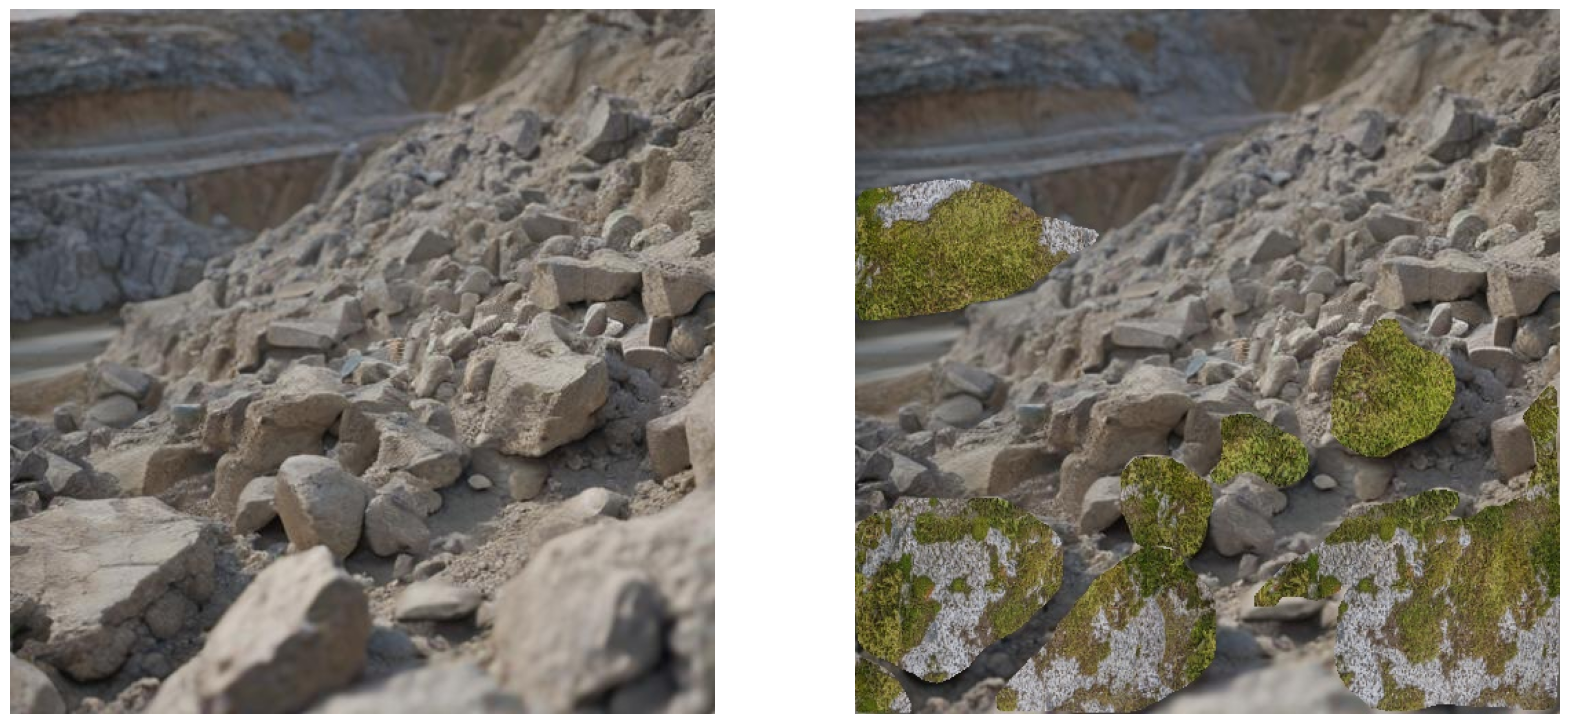

In [70]:
# Пример использования функции
input_image = 'photo_2024-10-09_10-53-38.jpg'
texture_image = 'texture_3.png'
output_image =  'augmented_image2.jpg'

apply_texture_to_detected_stones(input_image, texture_image, output_image, MODEL="m2")


dump_images(input_image, output_image)